# Análise Exploratória da Série Temporal do Preços do Café

1. Importação de Bibliotecas e Carregamento dos Dados

In [44]:
# Importa bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL


In [64]:
# Carrega os dados
PATH = r'C:\Users\luizz\Documents\GitHub\portfolio\coffee-series-models\data\raw\coffee_word_bank.xlsx'
df = pd.read_excel(PATH)
# Converte a coluna 'date' para datetime e define como índice
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,price
date,
1960-01-01,0.940900
1960-02-01,0.946900
1960-03-01,0.928100
1960-04-01,0.930300
1960-05-01,0.920000
...,...
2024-07-01,5.668078
2024-08-01,5.763759
2024-09-01,6.124655


2. Validação e Pré-processamento dos Dados

=== VALIDAÇÃO DE DADOS ===

Frequência detectada: MS
Período da série: 1960-01-01 00:00:00 até 2024-11-01 00:00:00
Total de observações: 779
Valores ausentes: 0 (0.00%)
Datas duplicadas: 0
Datas ausentes: 0 de 779 possíveis
Outliers (z-score > 3): 1 (0.13%)
Outliers (IQR): 4 (0.51%)

Principais outliers (top 5 por z-score):
             price  year
date                    
1977-04-01  7.0036  1977


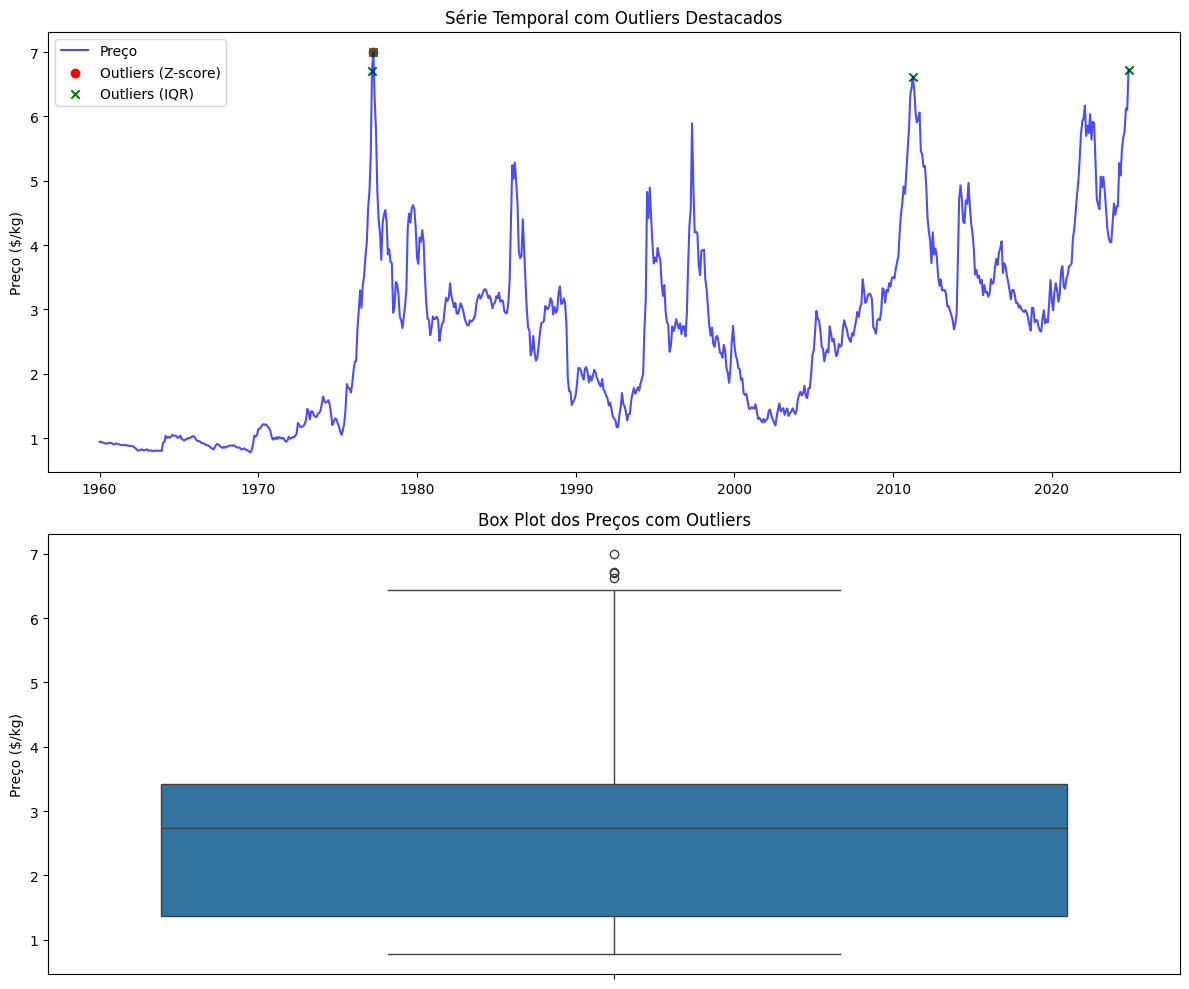


Sugestões para tratamento:
1. Manter outliers: podem representar eventos reais no mercado
2. Winsorização: substituir outliers por valores do percentil 5 e 95
3. Transformação: aplicar log ou raiz quadrada para reduzir efeito dos outliers
4. Imputação: substituir por médias móveis ou interpolação


In [55]:
def validate_data(df):
    """
    Realiza validação extensiva dos dados da série temporal.
    """
    print("=== VALIDAÇÃO DE DADOS ===\n")
    
    # Copia original para preservar
    df_original = df.copy()
    
    # Verifica a frequência dos dados
    print(f"Frequência detectada: {pd.infer_freq(df.index)}")
    
    # Período da série
    print(f"Período da série: {df.index.min()} até {df.index.max()}")
    print(f"Total de observações: {len(df)}")
    
    # Verifica valores ausentes
    missing = df['price'].isnull().sum()
    print(f"Valores ausentes: {missing} ({missing/len(df)*100:.2f}%)")
    
    # Verifica duplicatas no índice
    duplicates = df.index.duplicated().sum()
    print(f"Datas duplicadas: {duplicates}")
    
    # Verifica gaps na série temporal
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
    missing_dates = full_range.difference(df.index)
    print(f"Datas ausentes: {len(missing_dates)} de {len(full_range)} possíveis")
    
    if len(missing_dates) > 0 and len(missing_dates) < 20:
        print("Primeiras datas ausentes:")
        print(missing_dates[:10].tolist())
    
    # Verifica outliers usando o método z-score
    z_scores = np.abs(stats.zscore(df['price']))
    threshold = 3
    outliers = df[z_scores > threshold]
    print(f"Outliers (z-score > {threshold}): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    
    # Verifica outliers usando o método IQR 
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
    print(f"Outliers (IQR): {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")
    
    # Exibir os outliers principais
    if len(outliers) > 0:
        print("\nPrincipais outliers (top 5 por z-score):")
        print(outliers.sort_values(by='price', ascending=False).head(5))
    
    # Visualizar outliers
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Gráfico de série temporal com outliers destacados
    axes[0].plot(df.index, df['price'], 'b-', alpha=0.7, label='Preço')
    if len(outliers) > 0:
        axes[0].scatter(outliers.index, outliers['price'], color='red', label='Outliers (Z-score)')
    if len(outliers_iqr) > 0:
        axes[0].scatter(outliers_iqr.index, outliers_iqr['price'], color='green', marker='x', label='Outliers (IQR)')
    axes[0].set_title('Série Temporal com Outliers Destacados')
    axes[0].set_ylabel('Preço ($/kg)')
    axes[0].legend()
    
    # Box plot para visualizar distribuição com outliers
    sns.boxplot(y=df['price'], ax=axes[1])
    axes[1].set_title('Box Plot dos Preços com Outliers')
    axes[1].set_ylabel('Preço ($/kg)')
    
    plt.tight_layout()
    plt.show()
    
    # Sugestão de tratamento para outliers
    print("\nSugestões para tratamento:")
    print("1. Manter outliers: podem representar eventos reais no mercado")
    print("2. Winsorização: substituir outliers por valores do percentil 5 e 95")
    print("3. Transformação: aplicar log ou raiz quadrada para reduzir efeito dos outliers")
    print("4. Imputação: substituir por médias móveis ou interpolação")
    
    return df
df_validado = validate_data(df)

Destaca-se outliers usando duas metodologias, com picos extremos em 1977, 2011 e 2024.
O boxplot indica que valores acima de aproximadamente $6/kg são considerados outliers estatísticos.

3. Análise Estatísticas Descritiva

In [47]:
def basics_estatistics(df):
    """
    Retorna estatísticas básicas do dataframe
    """
    print(f"{df['price'].describe()}\n")
    print(df.info())
    
    return 

basics_estatistics(df)     

count    779.000000
mean       2.647307
std        1.388668
min        0.777600
25%        1.375468
50%        2.735700
75%        3.414515
max        7.003600
Name: price, dtype: float64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 779 entries, 1960-01-01 to 2024-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   779 non-null    float64
dtypes: float64(1)
memory usage: 28.3 KB
None


O preço médio do café é de $2.65/kg com desvio padrão de 1.39, indicando considerável variabilidade no período analisado. 
Apresenta valor minímo de $0.78/kg e valor máximo de $7.00/kg, uma variação de aproximadamente 9 vezes entre os valores. 

4. Visualizações

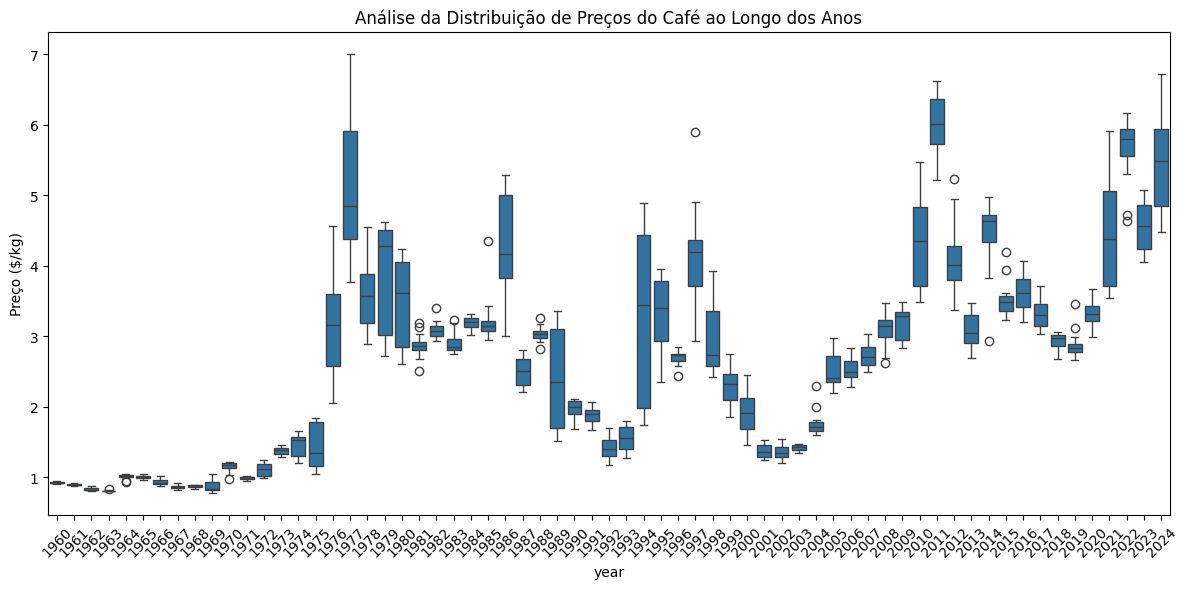

In [48]:
# Distribuição de Preços do Café por Ano
df['year'] = df.index.year
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='year', y='price', data=df, ax=ax)
ax.set_title('Análise da Distribuição de Preços do Café ao Longo dos Anos')
ax.set_ylabel('Preço ($/kg)')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


Períodos como 1977, 1994, 2011 e 2022-2024 apresentam não apenas preços mais altos, mas também maior variabilidade. 
Nota-se um aumento gradual da volatilidade nas últimas décadas em comparação com as décadas de 1960-1970.

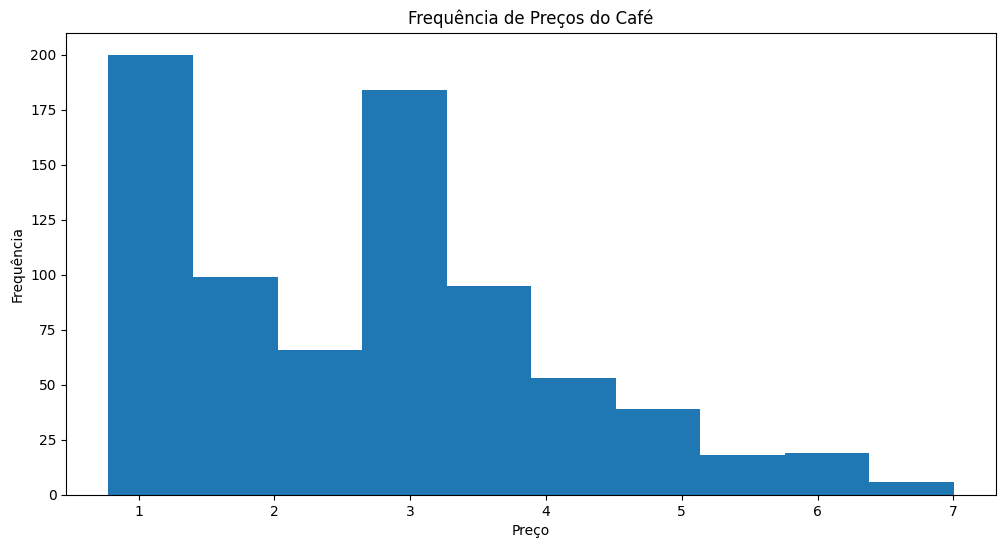

In [49]:
# Frequência de Preços do Café
plt.figure(figsize=(12, 6))
plt.hist(df['price'])
plt.title('Frequência de Preços do Café')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

Observa-se uma distribuição assimétrica positiva (cauda à direita), com maior concentração de preços nas faixas mais baixas ($1-3/kg) e baixa frequência nos preços elevados ($6-7/kg).

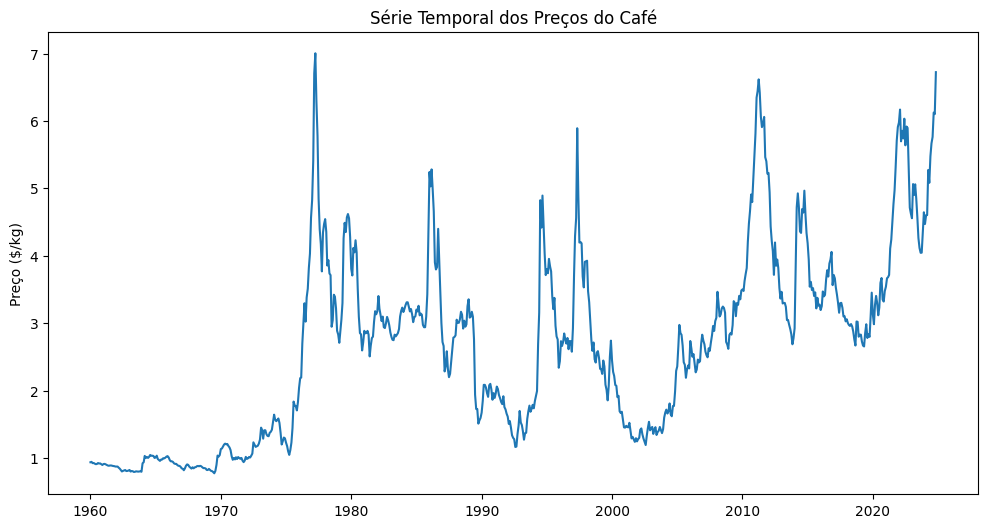

In [50]:
# Série Temporal dos Preços do Café
plt.figure(figsize=(12, 6))
plt.plot(df['price'])
plt.title('Série Temporal dos Preços do Café')
plt.ylabel('Preço ($/kg)')
plt.show()

Pode-se observar uma evolução dos preços do café desde 1960, com preços relativamente estáveis e baixos da década 1960 seguidos por múltiplos ciclos de alta volatilidade. 
Observam-se picos em aproximadamente 1977-1978 (próximo a $7/kg), 1986, 1997, 2011 e mais recentemente em 2022-2024.

5. Detecção de Outliers (simplificada, devido a validação anterior)

In [ ]:
#outliers = dectect_outliers(df, threshold=3)

6. Decomposição da Série

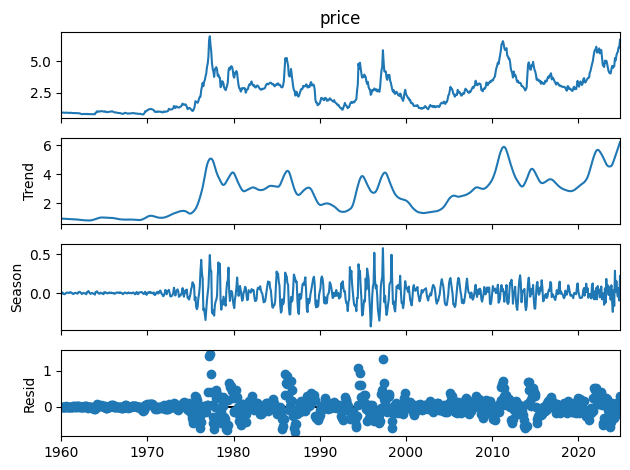

In [52]:
# Decomposição da Série Temporal com STL
stl = STL(df['price'], period=12)
result = stl.fit()
fig = result.plot()


Ao avaliar a decomposição da série temporal, observa-se a confirmação dos padrões já identificados, com valores estáveis, seguidos de picos significativos. 
A componente tendência revela ciclos de longo prazo, suavizando os rídos de curto prazo. 
Ao avaliar a sazonalidade, são identificados padrões cíclicos de curto prazo, com maior amplitude sazonal entre 1975 e 2000. Oscilações regulares, que sugerem efeitos sazonais na produção e consumo e redução gradual após 2010.
Notam-se maior dispersão de resíduos durante períodos de alta volatilidade e presença de alguns valores atípicos.

7. Exploração de Transfomações 

=== EXPLORANDO TRANSFORMAÇÕES ===

Parâmetro lambda Box-Cox: 0.3211


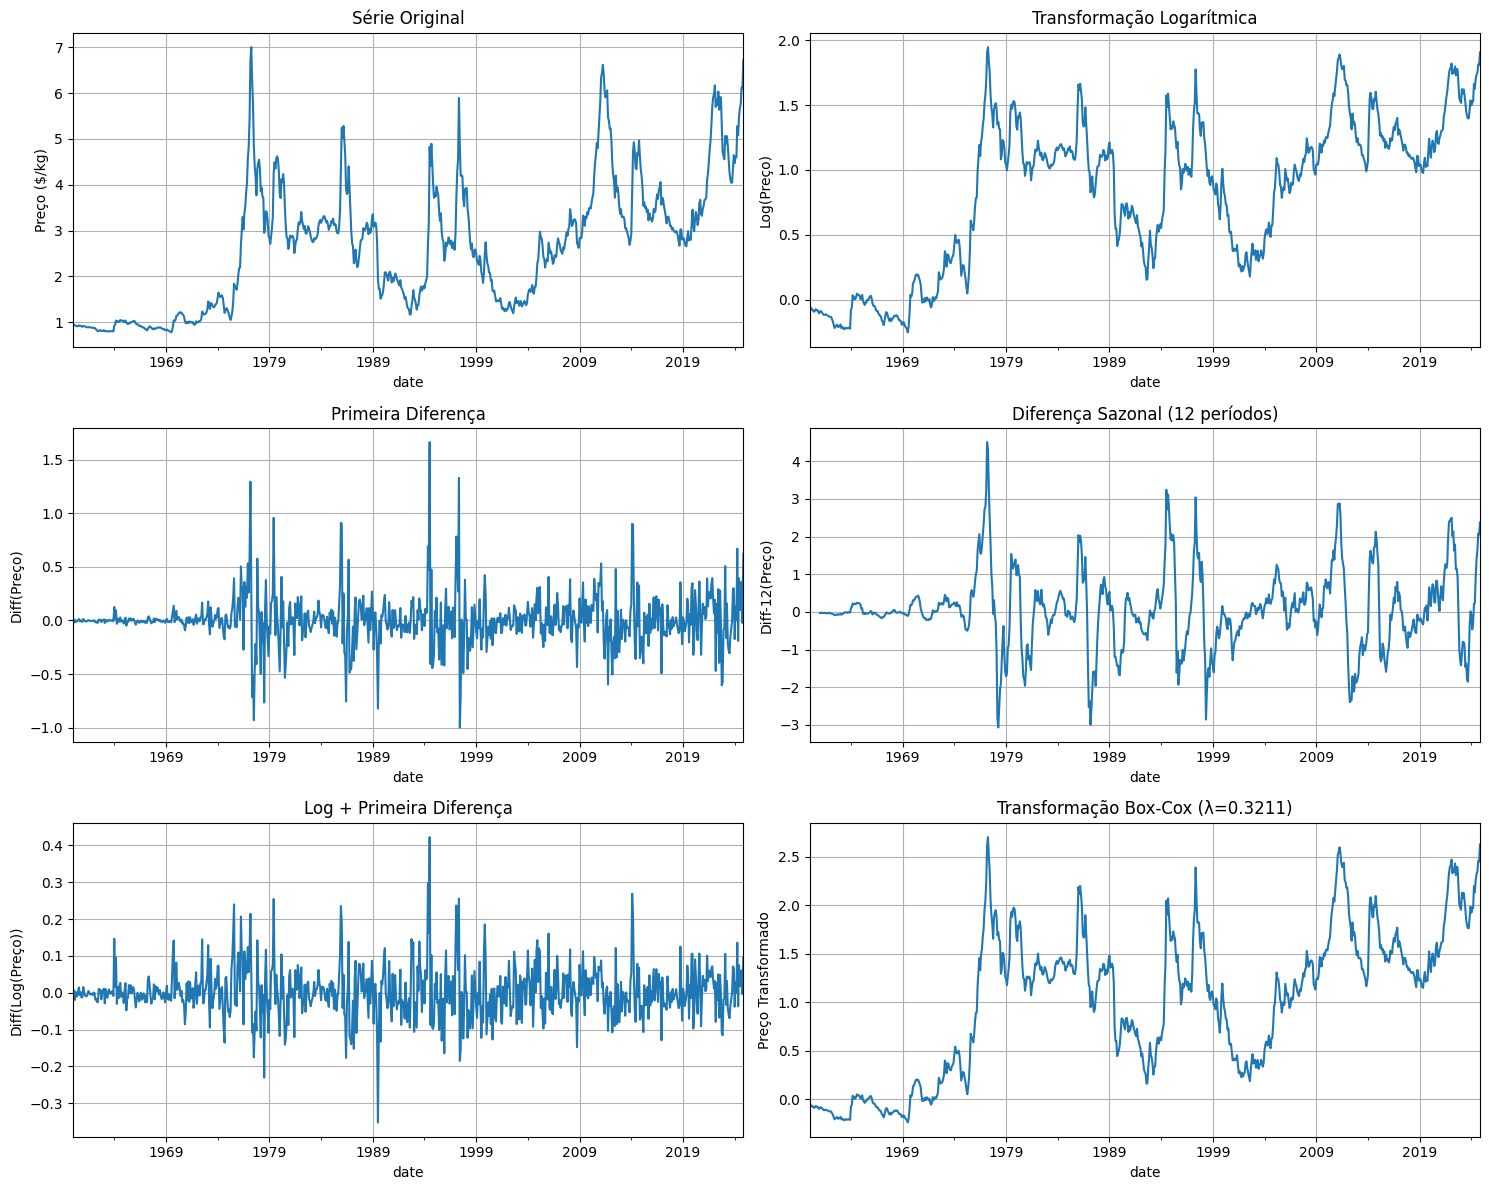


Testes de Estacionariedade para Séries Transformadas:

ORIGINAL:
  ADF Estatística: -1.6632
  p-valor: 0.4502
  Valores Críticos:
    1%: -3.4390
    5%: -2.8653
    10%: -2.5688
  Conclusão: Série não-estacionária (não rejeita H0)

LOG:
  ADF Estatística: -2.1289
  p-valor: 0.2331
  Valores Críticos:
    1%: -3.4388
    5%: -2.8653
    10%: -2.5688
  Conclusão: Série não-estacionária (não rejeita H0)

DIFF_1:
  ADF Estatística: -8.9450
  p-valor: 0.0000
  Valores Críticos:
    1%: -3.4390
    5%: -2.8653
    10%: -2.5688
  Conclusão: Série estacionária (rejeita H0)

DIFF_12:
  ADF Estatística: -6.6211
  p-valor: 0.0000
  Valores Críticos:
    1%: -3.4391
    5%: -2.8654
    10%: -2.5688
  Conclusão: Série estacionária (rejeita H0)

LOG_DIFF_1:
  ADF Estatística: -15.8771
  p-valor: 0.0000
  Valores Críticos:
    1%: -3.4388
    5%: -2.8653
    10%: -2.5688
  Conclusão: Série estacionária (rejeita H0)

BOXCOX:
  ADF Estatística: -2.2699
  p-valor: 0.1819
  Valores Críticos:
    1%: -3

In [56]:
def explore_transformations(df):
    """
    Explora transformações da série temporal para estabilizar variância e remover tendência.
    """
    print("=== EXPLORANDO TRANSFORMAÇÕES ===\n")
    
    # Criar dataframe para armazenar as transformações
    transformations = pd.DataFrame(index=df.index)
    transformations['original'] = df['price']
    
    # Transformação logarítmica (para estabilizar variância)
    transformations['log'] = np.log(df['price'])
    
    # Primeira diferença (para remover tendência)
    transformations['diff_1'] = df['price'].diff()
    
    # Diferença sazonal (assumindo sazonalidade anual com dados mensais)
    if len(df) >= 12:  # Verifica se há dados suficientes
        transformations['diff_12'] = df['price'].diff(12)
    
    # Primeira diferença do logaritmo (combinação de ambas abordagens)
    transformations['log_diff_1'] = np.log(df['price']).diff()
    
    # Transformação Box-Cox
    try:
        # Box-Cox requer dados positivos
        transformed_data, lambda_value = stats.boxcox(df['price'])
        transformations['boxcox'] = transformed_data
        print(f"Parâmetro lambda Box-Cox: {lambda_value:.4f}")
    except:
        print("Erro ao aplicar transformação Box-Cox (verifique valores negativos ou zero)")
    
    # Visualizar séries transformadas
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Original
    transformations['original'].plot(ax=axes[0], title='Série Original')
    axes[0].set_ylabel('Preço ($/kg)')
    axes[0].grid(True)
    
    # Log
    transformations['log'].plot(ax=axes[1], title='Transformação Logarítmica')
    axes[1].set_ylabel('Log(Preço)')
    axes[1].grid(True)
    
    # Diferença
    transformations['diff_1'].plot(ax=axes[2], title='Primeira Diferença')
    axes[2].set_ylabel('Diff(Preço)')
    axes[2].grid(True)
    
    # Diferença Sazonal
    if 'diff_12' in transformations.columns:
        transformations['diff_12'].plot(ax=axes[3], title='Diferença Sazonal (12 períodos)')
        axes[3].set_ylabel('Diff-12(Preço)')
        axes[3].grid(True)
    else:
        axes[3].set_title('Diferença Sazonal (Dados Insuficientes)')
        axes[3].set_axis_off()
    
    # Log-Diff
    transformations['log_diff_1'].plot(ax=axes[4], title='Log + Primeira Diferença')
    axes[4].set_ylabel('Diff(Log(Preço))')
    axes[4].grid(True)
    
    # Box-Cox
    if 'boxcox' in transformations.columns:
        transformations['boxcox'].plot(ax=axes[5], title=f'Transformação Box-Cox (λ={lambda_value:.4f})')
        axes[5].set_ylabel('Preço Transformado')
        axes[5].grid(True)
    else:
        axes[5].set_title('Box-Cox (Não Aplicável)')
        axes[5].set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    # Testar estacionariedade das transformações
    print("\nTestes de Estacionariedade para Séries Transformadas:")
    for col in transformations.columns:
        if col in ['diff_1', 'diff_12', 'log_diff_1']:
            # Pular primeiras observações que são NaN devido à diferenciação
            series = transformations[col].dropna()
        else:
            series = transformations[col]
        
        if len(series) > 10:  # Verifica se há dados suficientes
            result = adfuller(series)
            print(f"\n{col.upper()}:")
            print(f"  ADF Estatística: {result[0]:.4f}")
            print(f"  p-valor: {result[1]:.4f}")
            print(f"  Valores Críticos:")
            for key, value in result[4].items():
                print(f"    {key}: {value:.4f}")
            
            if result[1] <= 0.05:
                print("  Conclusão: Série estacionária (rejeita H0)")
            else:
                print("  Conclusão: Série não-estacionária (não rejeita H0)")
    
    # Calcular e exibir estatísticas de variabilidade para cada transformação
    variability = pd.DataFrame({
        'Desvio Padrão': transformations.std(),
        'IQR': transformations.quantile(0.75) - transformations.quantile(0.25),
        'Coef. Variação': transformations.std() / transformations.mean()
    })
    
    print("\nEstatísticas de Variabilidade das Transformações:")
    print(variability)
    
    print("\nInterpretação dos Resultados:")
    # Identificar a transformação com melhor resultado para estacionariedade
    try:
        best_transform = None
        best_pvalue = 1.0
        
        for col in transformations.columns:
            if col in ['diff_1', 'diff_12', 'log_diff_1', 'boxcox']:
                series = transformations[col].dropna()
                if len(series) > 10:
                    result = adfuller(series)
                    if result[1] < best_pvalue:
                        best_pvalue = result[1]
                        best_transform = col
        
        if best_transform and best_pvalue <= 0.05:
            print(f"- A transformação '{best_transform}' apresenta os melhores resultados para estacionariedade.")
            print(f"  (p-valor: {best_pvalue:.4f}, rejeita hipótese de não-estacionariedade)")
        else:
            print("- Nenhuma transformação alcançou estacionariedade ao nível de significância de 5%.")
    except:
        print("- Erro ao determinar a melhor transformação.")
    
    return transformations
transformations = explore_transformations(df)

8. Análise de Autocorrelação e Estacionariedade

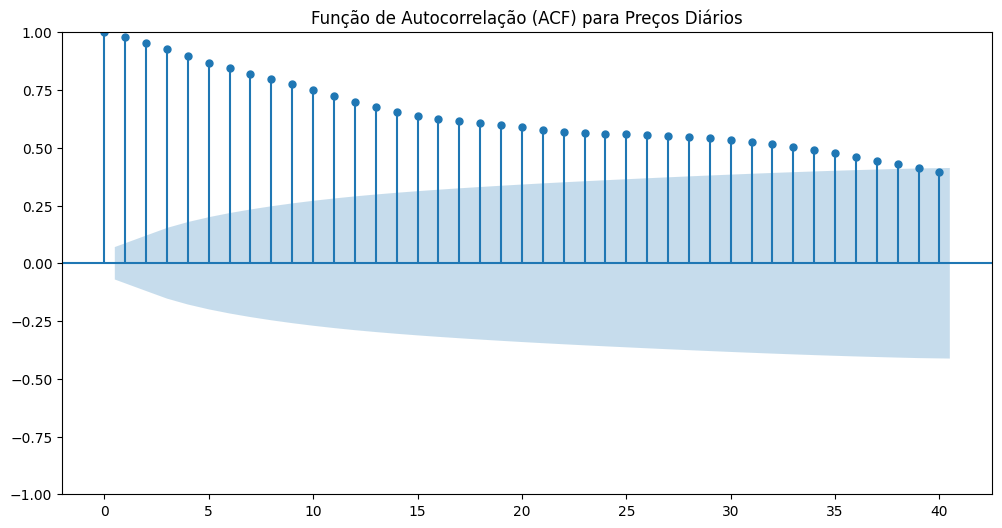

In [58]:
# Grafico de autocorrelação (ACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['price'], lags=40, ax=ax)
ax.set_title('Função de Autocorrelação (ACF) para Preços Diários')
plt.show()

Ao analisar a ACF, constata-se decaimento lento e gradual, típico de séries não estácionarias, com valores significativamente positivos mesmo em lags distantes. Este padrão sugere forte persistência e memória longa na série. 

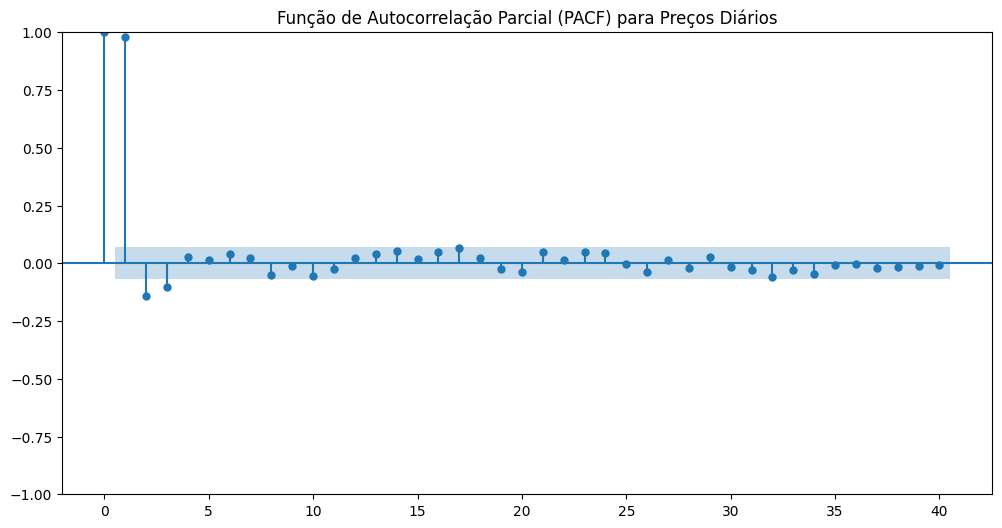

In [59]:
# Grafico de autocorrelação parcial (PACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df['price'], lags=40, ax=ax)
ax.set_title('Função de Autocorrelação Parcial (PACF) para Preços Diários')
plt.show()

Para a PACF, picos significativos nos lags 1 e 2, seguidos por correlações parciais muito menores. Este padrão é característico de processos autoregressivos de baixa ordem. Alguns picos menores em lags mais distantes sugerem possíveis efeitos sazonais.

In [34]:
def adf_test(df):
    """
    Realiza o teste ADF para verificar a estacionaridade da série temporal
    """
    result = adfuller(df['price'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    if result[1] <= 0.05:
        print("A série é estacionária")
    else:
        print("A série não é estacionária")

adf_test(df)

ADF Statistic: -1.6632196732946474
p-value: 0.4501554269939486
Critical Values: {'1%': np.float64(-3.4389608473398194), '5%': np.float64(-2.8653404270188476), '10%': np.float64(-2.568793735369693)}
A série não é estacionária


O teste ADF resultou em p-valor de 0.4515, rejeitando a hipótese nula
de não-estacionariedade. Isto sugere que não é estacionária em sua forma original.

9. Análise de Tendência

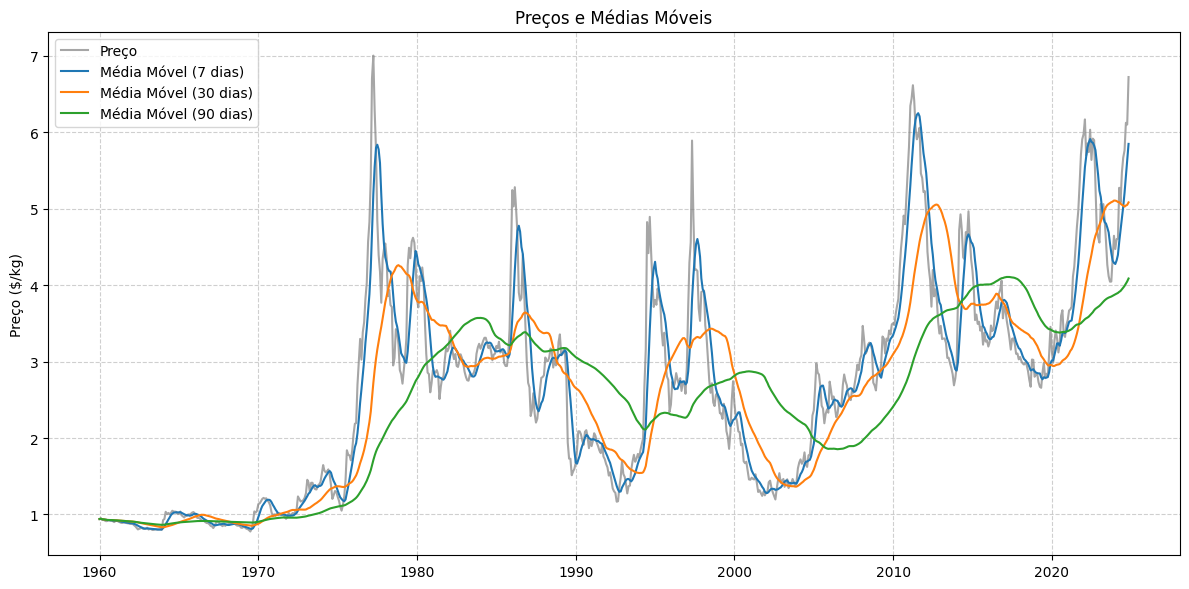

In [36]:
# Análise  de tendencia de longo prazo
def trend_analysis(df):
    """
    Realiza a análise de tendência da série temporal
    """
    # Define as janelas para as médias móveis
    windows = [7, 30, 90]
    # Cria um novo DataFrame para armazenar as médias, para não modificar o original
    rolling_means_df = pd.DataFrame(index=df.index)

    # Calcula a média móvel para cada janela
    for window in windows:
        col_name = f'MA_{window}'
        rolling_means_df[col_name] = df['price'].rolling(
            window=window, min_periods=1 # min_periods=1 para começar a calcular antes da janela completa
        ).mean()

    # Cria a figura e os eixos para o gráfico
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plota o preço original do DataFrame de entrada 'df'
    ax.plot(df.index, df['price'], label='Preço', alpha=0.7, color='grey')

    # Plota cada média móvel calculada (do rolling_means_df)
    for window in windows:
        col_name = f'MA_{window}'
        ax.plot(rolling_means_df.index, rolling_means_df[col_name],
                label=f'Média Móvel ({window} dias)') # Assume que os períodos são dias

    ax.set_title('Preços e Médias Móveis')
    ax.set_ylabel('Preço ($/kg)') 
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6) # Adiciona uma grade para facilitar a leitura
    plt.tight_layout() # Ajusta o layout para evitar sobreposição

    return fig
    
trend_analysis(df)
plt.show()

A tendência recente de alta parece robusta nas médias mais longas, sugerindo condições estruturais que favorecem preços elevados no médio prazo.

10. Análise de sazonalidade

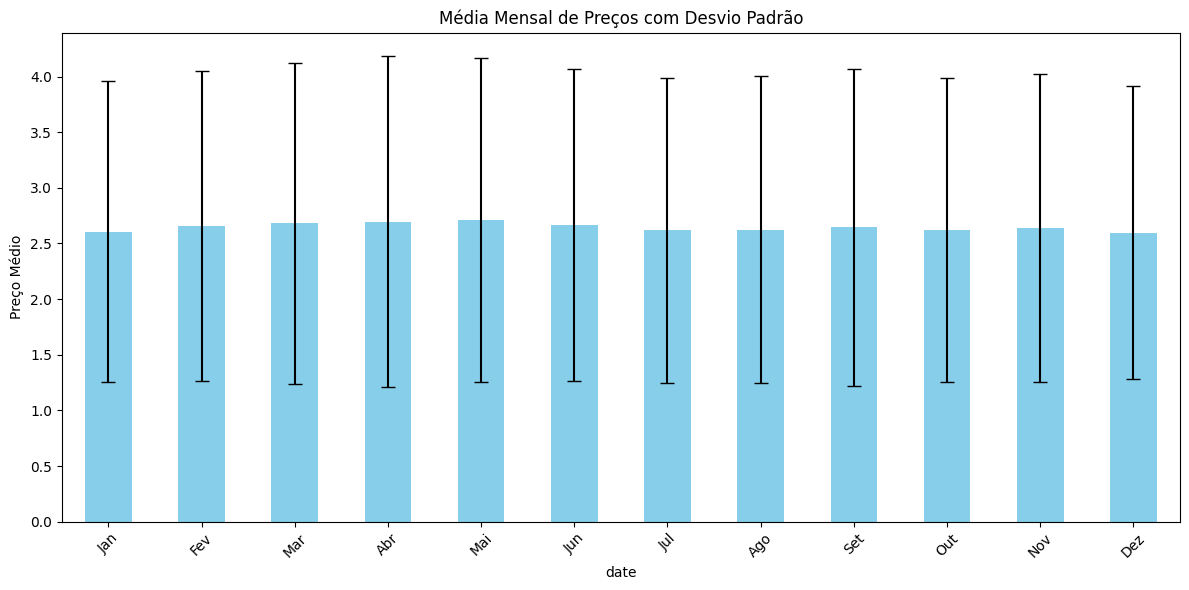

In [63]:
def seasonal_patterns(df):
        """Analisa padrões sazonais"""
        monthly_avg = df.groupby(df.index.month)['price'].mean()
        monthly_std = df.groupby(df.index.month)['price'].std()

        fig, ax = plt.subplots(figsize=(12, 6))
        monthly_avg.plot(kind='bar', yerr=monthly_std, ax=ax, color='skyblue', capsize=5)
        ax.set_title('Média Mensal de Preços com Desvio Padrão')
        ax.set_ylabel('Preço Médio')
        ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
                            'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)
        plt.tight_layout()
        plt.show() 

seasonal_patterns(df)      

As médias mensais mantêm-se consistentes durante todo o ano, sem evidência de sazonalidade pronunciada.

As barras de erro (desvio padrão) são similares em todos os meses, indicando que a volatilidade dos preços não apresenta um padrão claro. 

Essa ausência de padrão sugere que os ciclos de oferta e demanda globais tendem a se compensar devido à diversificação geográfica da produção (diferentes países produtores têm ciclos de safra distintos)
O armazenamento e a distribuição global atuam como mecanismos de estabilização, suavizando possíveis efeitos sazonais
Fatores não sazonais (climáticos irregulares, econômicos, geopolíticos) provavelmente exercem maior influência nas variações de preço do que padrões mensais recorrentes

Estatísticas Anuais dos Preços do Café:
         Média  Desvio Padrão    Mínimo    Máximo  Variação (%)
date                                                           
1960  0.923517       0.012831  0.900600  0.946900      5.141017
1961  0.895542       0.012661  0.877400  0.916700      4.479143
1962  0.832592       0.026132  0.804700  0.877400      9.034423
1963  0.805742       0.007697  0.797000  0.826700      3.726474
1964  1.009758       0.038545  0.925900  1.049000     13.295172
...        ...            ...       ...       ...           ...
2020  3.323630       0.197797  2.987260  3.672015     22.922509
2021  4.511939       0.826307  3.542383  5.910145     66.840926
2022  5.630434       0.499675  4.629482  6.169188     33.258727
2023  4.540047       0.377374  4.045919  5.064674     25.179817
2024  5.445131       0.721100  4.473174  6.723650     50.310498

[65 rows x 5 columns]


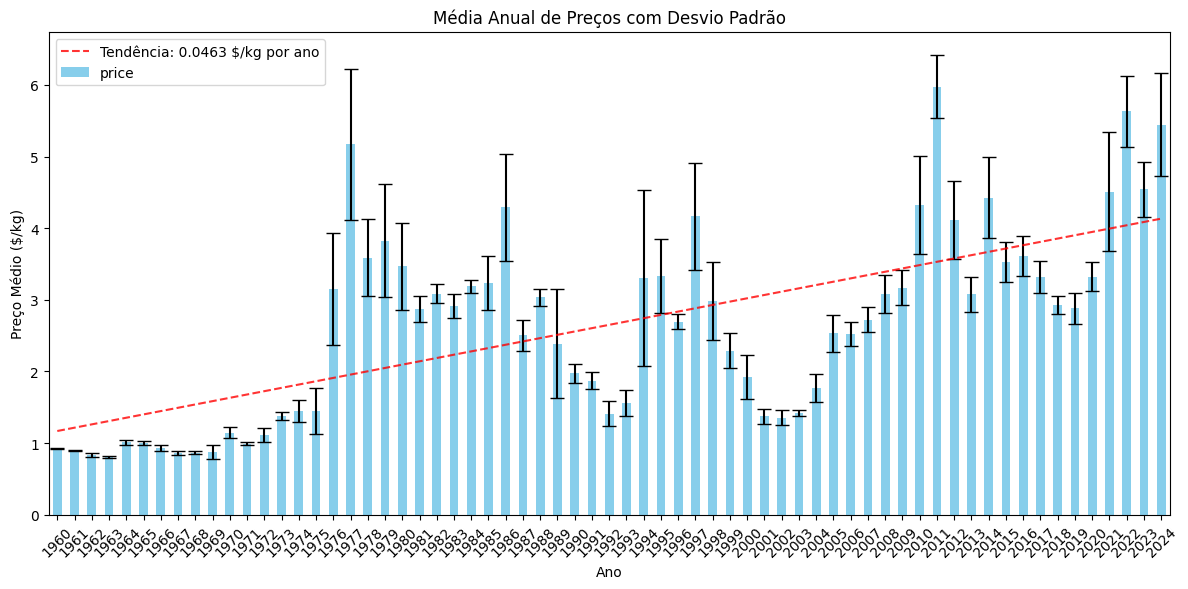


Interpretação dos Resultados:
- Anos com maior variabilidade: [1994, 1977, 2021]
- Anos com menor variabilidade: [1963, 1961, 1960]
- Tendência geral de aumento de preços: aproximadamente 0.0463 $/kg por ano


In [43]:
def seasonal_patterns_annual(df):
    """
    Analisa padrões sazonais anuais nos preços do café.
    """
    # Calcula estatísticas por ano
    annual_avg = df.groupby(df.index.year)['price'].mean()
    annual_std = df.groupby(df.index.year)['price'].std()
    annual_min = df.groupby(df.index.year)['price'].min()
    annual_max = df.groupby(df.index.year)['price'].max()
    
    # Cria uma tabela de estatísticas resumidas
    annual_stats = pd.DataFrame({
        'Média': annual_avg,
        'Desvio Padrão': annual_std,
        'Mínimo': annual_min,
        'Máximo': annual_max,
        'Variação (%)': (annual_max - annual_min) / annual_min * 100
    })
    
    # Mostra estatísticas
    print("Estatísticas Anuais dos Preços do Café:")
    print(annual_stats)
    
    # Cria visualização
    fig, ax = plt.subplots(figsize=(12, 6))
    annual_avg.plot(kind='bar', yerr=annual_std, ax=ax, color='skyblue', capsize=5)
    ax.set_title('Média Anual de Preços com Desvio Padrão')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Preço Médio ($/kg)')
    ax.set_xticklabels(annual_avg.index, rotation=45)
    
    # Adiciona linha de tendência para visualizar movimento de longo prazo
    years_numeric = np.arange(len(annual_avg))
    z = np.polyfit(years_numeric, annual_avg, 1)
    p = np.poly1d(z)
    ax.plot(years_numeric, p(years_numeric), "r--", alpha=0.8, 
            label=f'Tendência: {z[0]:.4f} $/kg por ano')
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Interpretação dos resultados
    print("\nInterpretação dos Resultados:")
    print(f"- Anos com maior variabilidade: {annual_std.nlargest(3).index.tolist()}")
    print(f"- Anos com menor variabilidade: {annual_std.nsmallest(3).index.tolist()}")
    
    # Identificar tendência geral
    if z[0] > 0:
        print(f"- Tendência geral de aumento de preços: aproximadamente {z[0]:.4f} $/kg por ano")
    else:
        print(f"- Tendência geral de queda de preços: aproximadamente {abs(z[0]):.4f} $/kg por ano")
    
    return fig

seasonal_patterns_annual(df)
plt.show()

Estas novas visualizações complementam e reforçam algumas de nossas análises anteriores:

A ausência de sazonalidade mensal explica por que os componentes sazonais identificados na decomposição da série temporal tinham amplitude menor em comparação com a tendência.
A tendência de longo prazo ascendente quantifica o aumento secular que havíamos observado nas análises anteriores.
O aumento da volatilidade anual a partir da década de 1970 coincide com mudanças estruturais importantes no mercado global de café, como mudanças na política internacional de preços. O que pode ser estudado de forma mais detalhada posteriormente.

O comportamento dos preços do café continua demonstrando a natureza complexa e multifatorial deste mercado, com influências tanto de tendências seculares quanto de choques exógenos irregulares, mas com surpreendente estabilidade em termos de padrões sazonais mensais.

Próximos Passos:

Para avançar com a análise e modelagem desta série temporal.
1. Preparação de Dados para Modelagem
2. Implementação e Avaliação de Modelos
3. Refinamento e Interpretação
4. Aplicações Práticas